# [Chapter 12] Predicting sale price in Ames using CART and RF

## [DSLC stages]: Analysis

The following code sets up the libraries and creates cleaned and pre-processed training, validation and test data that we will use in this document.


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, scale, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import tree
import statsmodels.api as sm
from itertools import product
from joblib import Parallel, delayed

# define all of the objects we need
%run functions/prepare_ames_data.py


pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

Since CART and RF can both use categorical features directly, let's create a version of the Ames data with the original categorical variables (i.e., without dummy variables) that we can use in this document.

In [2]:
ames_train_preprocessed_cat = preprocess_ames_data(ames_train_clean,
                                                   neighborhood_dummy = False, 
                                                   convert_categorical = "none")
ames_val_preprocessed_cat = preprocess_ames_data(ames_val_clean,
                                                 neighborhood_dummy = False,
                                                 convert_categorical = "none",
                                                 column_selection = ames_train_preprocessed_cat.columns,
                                                 neighborhood_levels = ames_train_preprocessed_cat['neighborhood'].unique())


## A manual CART demonstration

In this section, we will demonstrate one example of manually compute the first CART split for a small sample of 30 training houses.

First, let's create the sample of 30 training houses.


In [3]:
# define a list of the PID (house ID) values that were used in the R version
sampled_pids = [535153140, 902427140, 535180070, 902104020, 534277070, 534252090,
                907405140, 902300215, 907187040, 907200190, 534275220, 907192040,
                907175060, 535304170, 527425140, 907418010, 902328100, 907420060,
                535453020, 902206020, 535402100, 907262030, 534276010, 535179060,
                535376010, 907410100, 907251090, 907265100, 902109010, 902111010]
# create a version of the training data with just these houses 
ames_train_cat_sample = ames_train_preprocessed_cat.loc[sampled_pids]
ames_train_sample = ames_train_preprocessed.loc[sampled_pids]



Then, we can create a data frame with the set of potential split questions (each defined based on a variable and a threshold or value) we will consider for this small example:

In [4]:
ames_questions = pd.DataFrame({
    'variable': ['gr_liv_area', 'gr_liv_area', 'gr_liv_area', 'neighborhood', 'neighborhood'],
    'value': ['1625', '1428', '905', 'NAmes', 'CollgCr']
})

And define a function for computing the variance split measure for each split option.

In [5]:
def get_split_var(df, variable, value):
    # identify which observations answer "yes" to the split question
    if variable == "gr_liv_area":
        yes = df[variable] < float(value)
    elif variable == "neighborhood":
        yes = df[variable] == value
    # compute the variance of the responses for the observations that answer "yes"
    var_yes = df[yes]['saleprice'].var()
    # compute the variance of the responses for the observations that answer "no"
    var_no = df[~yes]['saleprice'].var()
    # compute a weighted sum of the two variances
    var_split = (sum(yes) / df.shape[0]) * var_yes + (sum(~yes) / df.shape[0]) * var_no 

    # create a nice character string describing of the current split question
    if variable == "gr_liv_area":
        split_rule = variable + " < " + str(value)
    elif variable == "neighborhood":
        split_rule = variable + " = " + str(value)
    # return the results
    return pd.DataFrame({'split': [split_rule], 'variance measure': [round(var_split)]})



Then we can apply this function to the set of potential split questions

In [6]:
# apply get_split_var() to each combination of values in ames_questions
pd.concat([get_split_var(ames_train_cat_sample, variable, value) for variable, value in zip(ames_questions['variable'], ames_questions['value'])])

,split,variance measure
0,gr_liv_area < 1625,1343422176
0,gr_liv_area < 1428,808915591
0,gr_liv_area < 905,1255484629
0,neighborhood = NAmes,1982880348
0,neighborhood = CollgCr,832579146


and we see that the split question, `gr_liv_area < 1428` yields the lowest variance for these 30 training houses, and so this is the threshold rule that we will use to define the first split.


Fortunately, you wouldn't have to do this manually yourself, since the `DecisionTreeRegressor()` function from sklearn will do it for you (although it will consider a much broader range of split options than the set that we considered above). Below, you can see that the `DecisionTreeRegressor()` function similarly identifies `gr_liv_area < 1428` as the best split option.

Unfortunately `DecisionTreeRegressor()` doesn't support categorical/string variables yet (only numeric variables can be provided)

In [7]:
x_ames_train_sample = np.array(ames_train_sample['gr_liv_area']).reshape(-1, 1)
y_ames_train_sample = ames_train_sample['saleprice']

ames_example_cart = DecisionTreeRegressor(max_depth = 1)
ames_example_cart.fit(x_ames_train_sample, y_ames_train_sample)

DecisionTreeRegressor(max_depth=1)

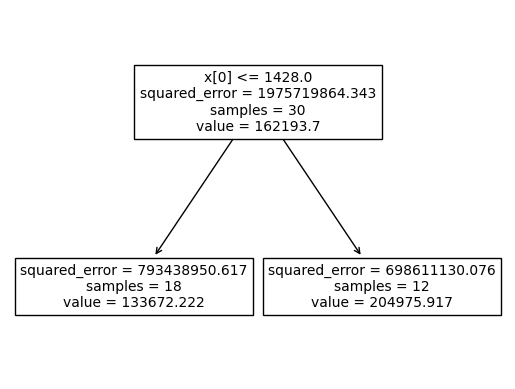

In [8]:
tree.plot_tree(ames_example_cart)
plt.show()


## Fitting CART and RF using the entire training set

Below, we fit a CART algorithm using the entire training dataset using all of the available features.

In [9]:
x_ames_train = ames_train_preprocessed.drop(columns='saleprice')
y_ames_train = ames_train_preprocessed['saleprice']

ames_cart = DecisionTreeRegressor()
ames_cart.fit(x_ames_train, y_ames_train)
cart_val_pred = ames_cart.predict(ames_val_preprocessed.drop(columns='saleprice'))


We can also fit a RF algorithm using the entire training dataset and all available features using the `()` function from the sklearn.

In [10]:
ames_rf = RandomForestRegressor(random_state=764)
ames_rf.fit(ames_train_preprocessed.drop(columns='saleprice'), y_ames_train)
rf_val_pred = ames_rf.predict(ames_val_preprocessed.drop(columns='saleprice'))

## RF variable importance


By default, `RandomForestRegressor()` computes the "impurity" importance measure, but it reports it in terms of the "mean decrease in impurity" (which is different to R). 


In [11]:
impurity_importance_df = pd.DataFrame({
    'variable': x_ames_train.columns,
    'importance': ames_rf.feature_importances_
}).sort_values('importance')
impurity_importance_df

,variable,importance
40,neighborhood_Gilbert,0.000100
41,neighborhood_Mitchel,0.000117
46,neighborhood_Somerst,0.000125
38,neighborhood_CollgCr,0.000215
43,neighborhood_NWAmes,0.000220
42,neighborhood_NAmes,0.000222
26,foundation_cinder,0.000245
37,neighborhood_BrkSide,0.000268
45,neighborhood_Sawyer,0.000276
27,foundation_concrete,0.000310


To compute the permutation importance, we can use the `permutation_importance()` function

In [12]:
permutation_importance_df = pd.DataFrame({
    'variable': x_ames_train.columns,
    'importance': permutation_importance(ames_rf, 
                                          x_ames_train, 
                                          y_ames_train, 
                                          n_repeats = 10, 
                                          random_state = 0).importances_mean
}).sort_values('importance')
permutation_importance_df

,variable,importance
46,neighborhood_Somerst,0.000038
41,neighborhood_Mitchel,0.000048
40,neighborhood_Gilbert,0.000061
43,neighborhood_NWAmes,0.000063
38,neighborhood_CollgCr,0.000087
45,neighborhood_Sawyer,0.000103
42,neighborhood_NAmes,0.000109
39,neighborhood_Edwards,0.000155
26,foundation_cinder,0.000166
32,porch,0.000170



And we can visualize these importance measures using a bar plot:

In [13]:
px.bar(permutation_importance_df, 
       y='variable', 
       x='importance', 
       orientation='h', 
       title='Permutation Importance',
       height=1000)

In [14]:
px.bar(impurity_importance_df, 
       y='variable', 
       x='importance', 
       orientation='h', 
       title='Impurity Importance',
       height=1000)

Note that these results look slightly different to the R/book version for two reasons:

1. The scikitlearn version we are using here does not accept categorical variables, so we are using the pre-processed version of the data in which all categorical variables have been converted to dummy or numeric variables.

2. The Python implementation of RF uses slighly different default values than the R version.



## A PCS evaluation of the CART and RF fits

And we can then evaluate the predictability and stability of this CART fit!



### Predictability

Let's evaluate the CART fit using the validation set. This will involve generating validation set predictions, which we can then compare to the original LS (all) fit.

First, let's create a version of the original LS fit

In [15]:
ls_all = LinearRegression()
ls_all.fit(X=x_ames_train, y=y_ames_train)
ls_all_val_pred = ls_all.predict(ames_val_preprocessed.drop(columns='saleprice'))

Then we can compare the performance of each fit on the validation set:

In [16]:
# evaluate the rMSE, MAE and correlation of each fit
# create an empty list to store the results
val_results = []
# compute the rMSE, MAE and correlation for each fit
val_results.append({'model': 'ls_all',
                    'rmse': np.sqrt(np.mean((ames_val_preprocessed['saleprice'] - ls_all_val_pred)**2)),
                    'mae': np.mean(abs(ames_val_preprocessed['saleprice'] - ls_all_val_pred)),
                    'corr': np.corrcoef(ames_val_preprocessed['saleprice'], ls_all_val_pred)[0, 1]})
val_results.append({'model': 'cart',
                    'rmse': np.sqrt(np.mean((ames_val_preprocessed['saleprice'] - cart_val_pred)**2)),
                    'mae': np.mean(abs(ames_val_preprocessed['saleprice'] - cart_val_pred)),
                    'corr': np.corrcoef(ames_val_preprocessed['saleprice'], cart_val_pred)[0, 1]})
val_results.append({'model': 'rf',
                    'rmse': np.sqrt(np.mean((ames_val_preprocessed['saleprice'] - rf_val_pred)**2)),
                    'mae': np.mean(abs(ames_val_preprocessed['saleprice'] - rf_val_pred)),
                    'corr': np.corrcoef(ames_val_preprocessed['saleprice'], rf_val_pred)[0, 1]})
# convert the results into a data frame
val_results_df = pd.DataFrame(val_results)
val_results_df

,model,rmse,mae,corr
0,ls_all,23250.505397,17311.648732,0.942223
1,cart,32175.510188,22526.058176,0.887228
2,rf,23063.038759,15409.591190,0.942894


Notice from the table above that the CART algorithm is *worse* across all measures than the LS fit. 

Note that these results are slightly different, but similar overall in theme to the book/R version, however here the CART fit is performing better than the R version (recall that the implementation of CART is slightly different). 



### Stability to data perturbations


To assess the stability of our data to appropriate perturbations in the data, we first need to decide what makes an "appropriate" perturbation. That is, what type of data perturbation (e.g., adding random noise, or performing subsampling) most resembles the way that the data *could* have been measured or collected differently, as well as how these results will be applied in the future. 


While the Ames housing data does not correspond to a random sample from a greater population of houses, each house is more-or-less exchangeable, meaning that a random sampling technique would be a reasonable perturbation, so we will draw 100 bootstrap samples of the original data. 

Moreover, it is plausible that the living area measurements involve a slight amount of measurement error, although we do not have a realistic sense of how much. To really stress-test our results, we choose to add another perturbation to the data that involves adding some random noise to 30% of the `gr_liv_area` measurements. Since the standard deviation of the living area is approximately 500, we decide to add or subtract a random number between 0 and 250 (i.e. add noise up to half a standard deviation) to 30% of `gr_liv_area` observations.

Since we will be repeating this analysis many times, we will write a function that will take an Ames dataset, and return a perturbed version of it.

In [17]:
# write a function that takes the ames_train_preprocessed data frame and creates a bootstrap sample of the same size
# and perturbs the gr_liv_area column by adding a random number between -250 and 250 to 30% of the values
def perturb_ames(df):
    # create a copy of the data frame
    df_copy = df.copy()
    # generate a random number between -250 and 250 for 30% of the rows
    sampled_index = df_copy.sample(frac=0.3).index
    df_copy.loc[sampled_index, 'gr_liv_area'] = df_copy.loc[sampled_index, 'gr_liv_area'] + np.random.randint(-250, 250, size=sampled_index.size)
    # conduct bootstrap sample
    df_copy = df_copy.sample(frac=1, replace=True)
    return df_copy

Below we create 100 perturbed versions of the training data:

In [18]:
# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_ames = [perturb_ames(ames_train_preprocessed) for i in range(100)]

Then we can apply each fit to each perturbed dataset

In [19]:
# This code takes a while to run, so we will use the joblib library to parallelize the code
def fit_models(df):
    
    ls_all = LinearRegression().fit(X=df.drop(columns='saleprice'), y=df['saleprice'])
    cart_fit = DecisionTreeRegressor().fit(X=df.drop(columns='saleprice'), y=df['saleprice'])
    rf_fit = RandomForestRegressor().fit(X=df.drop(columns='saleprice'), y=df['saleprice'])
    
    return (ls_all, cart_fit, rf_fit)

In [20]:
# compute the fits for each perturbed dataset
results = Parallel(n_jobs=-1)(delayed(fit_models)(df) for df in perturbed_ames)
ls_all_perturbed, cart_perturbed, rf_perturbed = zip(*results)

We can then generate sale price predictions for each house in the validation set using each perturbed LS fits.

In [21]:
# compute the predictions on the validaion set for ls_all_perturbed, cart_perturbed and rf_perturbed
ls_all_val_pred_perturbed = [ls_all_perturbed[i].predict(X=ames_val_preprocessed.drop(columns='saleprice')) for i in range(100)]
cart_val_pred_perturbed = [cart_perturbed[i].predict(X=ames_val_preprocessed.drop(columns='saleprice')) for i in range(100)]
rf_val_pred_perturbed = [rf_perturbed[i].predict(X=ames_val_preprocessed.drop(columns='saleprice')) for i in range(100)]

Let's define a prediction stability plot function

In [22]:
# define a function that takes a list of predictions from ls_perturbed_pred and creates line segment plots for the 
# range of predictions for each id corresponding to the position in each list entry

def plot_prediction_range(pred_list, title=None, sample_index=None):
    if sample_index is None:
        sample_index = list(range(pred_list[0].size))
        
    pred_list = [pred_list[i][sample_index] for i in range(100)]
    pred_list_df = pd.DataFrame(pred_list).T
    pred_list_df['id'] = ames_val_preprocessed.index[sample_index]
    pred_list_df['true'] = ames_val_preprocessed['saleprice'].values[sample_index]
    pred_list_df = pd.melt(pred_list_df, id_vars=['id','true'], var_name='iter', value_name='pred')
    pred_list_df = pred_list_df.groupby(['id', 'true']).agg({'pred': ['min', 'max']})
    pred_list_df = pred_list_df.reset_index()
    pred_list_df = pred_list_df.set_index('id')

    # plot a series of horizontal line segments for each id where the lines range from the minimum and maximum predicted values on the x-axis and have the true value on the y-axis
    fig = go.Figure()

    for i in pred_list_df.index:
        fig.add_trace(
            go.Scatter(x=[pred_list_df.loc[i, ('pred', 'min')], pred_list_df.loc[i, ('pred', 'max')]],
                        y=[pred_list_df.loc[i, 'true'].values[0], pred_list_df.loc[i, 'true'].values[0]],
                        mode='lines',
                        line={'color': 'black'}, 
                        showlegend=False)
            )
    # add a single diagonal line to the plot
    fig.add_trace(
        go.Scatter(x=[0, 400000], y=[0, 400000], mode='lines', line={'color': 'black'}, showlegend=False)
    )
        
    fig.update_layout(xaxis_title='Predicted sale price range',
                        yaxis_title='Observed sale price',
                        title=title)
    return fig


Let's use the prediction stability plot function to visualize the range of perturbed predictions for 150 validation set houses for each fit. 


In [23]:
val_sample_id = np.random.choice(ames_val_preprocessed.shape[0], 150, replace=False)
plot_prediction_range(ls_all_val_pred_perturbed, 'LS (all)', sample_index=val_sample_id)

In [24]:
plot_prediction_range(cart_val_pred_perturbed, 'LS (all)', sample_index=val_sample_id)

In [25]:
plot_prediction_range(rf_val_pred_perturbed, 'LS (all)', sample_index=val_sample_id)


Clearly the CART algorithm is much *less* stable than the LS or RF algorithms, but the RF algorithm looks to have similar stability to the LS algorithm.

Below, we show the average length of the intervals for each algorithm. In the R version in the book, we found that the RF algorithm was slightly more stable than the LS algorithm, but this doesn't seem to be the case for the scikit-learn version we've implemented here. In both cases, however, the CART algorithm is much less stable than the other two algorithms. 


In [26]:
print(f"LS (all) average sd: {pd.DataFrame(ls_all_val_pred_perturbed).std(axis=0).mean()}")
print(f"CART average sd: {pd.DataFrame(cart_val_pred_perturbed).std(axis=0).mean()}")
print(f"RF average sd: {pd.DataFrame(rf_val_pred_perturbed).std(axis=0).mean()}")


LS (all) average sd: 5715.538550916125
CART average sd: 23577.92390134233
RF average sd: 7644.756851684437


We can also investigate the distribution of the correlation performance across the data perturbations for each model. From the boxplots below, it is clear that the distribution of the correlation performance measure for the CART algorithm is much less stable to the data perturbations than for the LS and RF algorithms.

In [27]:
cor_perturbed = pd.DataFrame({
    'ls_all': [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in ls_all_val_pred_perturbed],
    'cart': [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in cart_val_pred_perturbed],
    'rf': [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in rf_val_pred_perturbed]
}).melt(var_name='model', value_name='cor')

In [28]:
px.box(cor_perturbed, x='model', y='cor', title='Correlation of predictions with true values')



### Stability to judgment call perturbations

Next, we can compare the stability of each algorithm to the pre-processing judgment calls.


In [29]:
perturb_options = list(product([0.65, 0.8, 0.95], 
                               [10, 20],
                               ['other', 'mode'],
                               [True, False],
                               ['none', 'log', 'sqrt'],
                               [0, 0.5],
                               ['numeric', 'simplified_dummy', 'dummy']))
perturb_options = pd.DataFrame(perturb_options, columns=('max_identical_thresh', 
                                                         'n_neighborhoods',
                                                         'impute_missing_categorical',
                                                         'simplify_vars',
                                                         'transform_response',
                                                         'cor_feature_selection_threshold',
                                                         'convert_categorical'))
perturb_options

,max_identical_thresh,n_neighborhoods,impute_missing_categorical,simplify_vars,transform_response,cor_feature_selection_threshold,convert_categorical
0,0.65,10,other,True,none,0.0,numeric
1,0.65,10,other,True,none,0.0,simplified_dummy
2,0.65,10,other,True,none,0.0,dummy
3,0.65,10,other,True,none,0.5,numeric
4,0.65,10,other,True,none,0.5,simplified_dummy
...,...,...,...,...,...,...,...
427,0.95,20,mode,False,sqrt,0.0,simplified_dummy
428,0.95,20,mode,False,sqrt,0.0,dummy
429,0.95,20,mode,False,sqrt,0.5,numeric
430,0.95,20,mode,False,sqrt,0.5,simplified_dummy


Then we need to create a cleaned/pre-processed version of the training and validation datasets for each combination of these judgment calls:

In [30]:
# conduct judgment call perturbations of training data
ames_jc_perturb = [preprocess_ames_data(ames_train_clean,
                                        max_identical_thresh=perturb_options['max_identical_thresh'][i],
                                        n_neighborhoods=perturb_options['n_neighborhoods'][i],
                                        impute_missing_categorical=perturb_options['impute_missing_categorical'][i],
                                        simplify_vars=perturb_options['simplify_vars'][i],
                                        transform_response=perturb_options['transform_response'][i],
                                        cor_feature_selection_threshold=perturb_options['cor_feature_selection_threshold'][i],
                                        convert_categorical=perturb_options['convert_categorical'][i])
                   for i in range(perturb_options.shape[0])]

# conduct judgment call perturbations of validation data data (we need to make sure each validation set is compartible with the relevant training set)
ames_val_jc_perturb = []
for i in range(perturb_options.shape[0]):
    
    # extract relevant neighborhoods from  relevant training data
    train_neighborhood_cols = list(ames_jc_perturb[i].filter(regex="neighborhood").columns)
    train_neighborhoods = [x.replace("neighborhood_", "") for x in train_neighborhood_cols]
    
    # create preprocessed validation set
    ames_val_jc_perturb.append(
        preprocess_ames_data(ames_val_clean,
                             max_identical_thresh=perturb_options['max_identical_thresh'][i],
                             n_neighborhoods=perturb_options['n_neighborhoods'][i],
                             impute_missing_categorical=perturb_options['impute_missing_categorical'][i],
                             simplify_vars=perturb_options['simplify_vars'][i],
                             transform_response=perturb_options['transform_response'][i],
                             cor_feature_selection_threshold=perturb_options['cor_feature_selection_threshold'][i],
                             convert_categorical=perturb_options['convert_categorical'][i],
                             # make sure val set matches training set
                             column_selection=list(ames_jc_perturb[i].columns),
                             neighborhood_levels=train_neighborhoods)
        )


Then we can essentially repeat the code from above, but for these judgment call-perturbed datasets. However, since the judgment calls primarily don't affect the single-predictor and 5-predictor fits, we will just focus on the LS (all predictor) fit and the lasso and ridge regularized fits.


In [31]:
# compute the fits for each perturbed dataset
# Note some of the fits don't converge but for simplicity we will ignore this for now
results_jc = Parallel(n_jobs=-1)(delayed(fit_models)(df) for df in ames_jc_perturb)
ls_all_jc_perturbed, cart_jc_perturbed, rf_jc_perturbed = zip(*results_jc)

In [32]:
# compute the predictions on the validaion set for ls_area_perturbed, ls_multi_perturbed, ls_all_perturbed, cart_perturbed, and rf_perturbed
ls_all_val_jc_pred_perturbed = [ls_all_jc_perturbed[i].predict(X=ames_val_jc_perturb[i].drop(columns='saleprice')) for i in range(len(ames_val_jc_perturb))]
cart_val_jc_pred_perturbed = [cart_jc_perturbed[i].predict(X=ames_val_jc_perturb[i].drop(columns='saleprice')) for i in range(len(ames_val_jc_perturb))]
rf_val_jc_pred_perturbed = [rf_jc_perturbed[i].predict(X=ames_val_jc_perturb[i].drop(columns='saleprice')) for i in range(len(ames_val_jc_perturb))]


In [33]:

# for predictions where the response was log-transformed, undo the log transformation
ls_all_val_jc_pred_perturbed = [np.exp(pred) if perturb_options['transform_response'][i] == 'log' else pred for i, pred in enumerate(ls_all_val_jc_pred_perturbed)]
cart_val_jc_pred_perturbed = [np.exp(pred) if perturb_options['transform_response'][i] == 'log' else pred for i, pred in enumerate(cart_val_jc_pred_perturbed)]
rf_val_jc_pred_perturbed = [np.exp(pred) if perturb_options['transform_response'][i] == 'log' else pred for i, pred in enumerate(rf_val_jc_pred_perturbed)]

# for predictions where the response was sqrt-transformed, undo the sqrt transformation
ls_all_val_jc_pred_perturbed = [pred**2 if perturb_options['transform_response'][i] == 'sqrt' else pred for i, pred in enumerate(ls_all_val_jc_pred_perturbed)]
cart_val_jc_pred_perturbed = [pred**2 if perturb_options['transform_response'][i] == 'sqrt' else pred for i, pred in enumerate(cart_val_jc_pred_perturbed)]
rf_val_jc_pred_perturbed = [pred**2 if perturb_options['transform_response'][i] == 'sqrt' else pred for i, pred in enumerate(rf_val_jc_pred_perturbed)]


We next want to use it to visualize the range of perturbed predictions for 150 validation set houses for each fit. However, first, we should filter any particularly poorly performing fits. To identify whether there are any particularly poorly performing fits, let's compute the correlation predictive performance for each fit to each perturbed dataset and visualize their distributions across the different fits and judgment calls.

In [34]:
# compute the correlation between the predictions and the true values for each model
# note that we are using the sale price from the unperturbed validation set because to use the perturbed sale price
# we would need to un log- or sqrt-transform the sale price where relevant
# this wouldn't work if any of our judgment call modifications changed the *number* of observations in the data
ls_all_val_jc_corr = [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in ls_all_val_jc_pred_perturbed]
cart_val_jc_corr = [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in cart_val_jc_pred_perturbed]
rf_val_jc_corr = [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in rf_val_jc_pred_perturbed]

# a couple of the CART fits yielded identical predictions for all observations, which results in a correlation of NaN

In [35]:
# Create a boxplot of the correlations for each fit against each judgment call combination
corr_jc_df = pd.DataFrame({'ls_all': ls_all_val_jc_corr,
                        'cart': cart_val_jc_corr,
                        'rf': rf_val_jc_corr,
                        'max_identical_thresh': perturb_options['max_identical_thresh'],
                        'n_neighborhoods': perturb_options['n_neighborhoods'],
                        'impute_missing_categorical': perturb_options['impute_missing_categorical'],
                        'simplify_vars': perturb_options['simplify_vars'],
                        'transform_response': perturb_options['transform_response'],
                        'cor_feature_selection_threshold': perturb_options['cor_feature_selection_threshold'],
                        'convert_categorical': perturb_options['convert_categorical']})

# melt corr_df by the model
corr_jc_df = pd.melt(corr_jc_df, id_vars=['max_identical_thresh', 
                                    'n_neighborhoods',
                                    'impute_missing_categorical',
                                    'simplify_vars',
                                    'transform_response',
                                    'cor_feature_selection_threshold',
                                    'convert_categorical'],
                  value_vars=['ls_all', 'cart', 'rf'],
                  var_name='model',
                  value_name='corr')

corr_jc_df.sort_values(by='corr', ascending=False)

,max_identical_thresh,n_neighborhoods,impute_missing_categorical,simplify_vars,transform_response,cor_feature_selection_threshold,convert_categorical,model,corr
427,0.95,20,mode,False,sqrt,0.0,simplified_dummy,ls_all,0.968213
426,0.95,20,mode,False,sqrt,0.0,numeric,ls_all,0.968187
391,0.95,20,other,False,sqrt,0.0,simplified_dummy,ls_all,0.968153
390,0.95,20,other,False,sqrt,0.0,numeric,ls_all,0.967781
385,0.95,20,other,False,log,0.0,simplified_dummy,ls_all,0.967483
...,...,...,...,...,...,...,...,...,...
454,0.65,10,other,False,none,0.5,simplified_dummy,cart,0.847706
742,0.95,10,other,False,none,0.5,simplified_dummy,cart,0.843084
490,0.65,10,mode,False,none,0.5,simplified_dummy,cart,0.842703
453,0.65,10,other,False,none,0.5,numeric,cart,0.840427


In [36]:
corr_jc_df_long = corr_jc_df.melt(id_vars=['corr', 'model'],
                            value_vars=['max_identical_thresh',
                                        'n_neighborhoods',
                                        'impute_missing_categorical',
                                        'simplify_vars',
                                        'transform_response',
                                        'cor_feature_selection_threshold',
                                        'convert_categorical'],
                            var_name='judgment_call',
                            value_name='option')
fig = px.box(corr_jc_df_long, x='option', y='corr', 
       color='model', 
       facet_col='judgment_call', 
       facet_col_wrap=2, 
       height=1200)

# give each plot in the 4 by 2 fig above its own x-axis
fig.update_xaxes(matches=None, showticklabels=True)
fig.update_yaxes(matches=None)


The CART algorithm is overall much less accurate than the other two, but none of the judgment calls seem to be affecting the accuracy all that much.


Let's create a prediction stability plot for each fit


In [37]:
plot_prediction_range(ls_all_val_jc_pred_perturbed, 'LS (all)', sample_index=val_sample_id)

In [38]:
plot_prediction_range(cart_val_jc_pred_perturbed, 'LS (all)', sample_index=val_sample_id)

In [39]:
plot_prediction_range(rf_val_jc_pred_perturbed, 'LS (all)', sample_index=val_sample_id)


This time, both the CART and RF algorithms appear to be *more* stable to the judgment call perturbations than the LS algorithm.


To confirm this observation, the average SD of the perturbed predictions for each algorithm is shown below:



In [40]:
print(f"LS (all) average sd: {pd.DataFrame(ls_all_val_jc_pred_perturbed).std(axis=0).mean()}")
print(f"CART average sd: {pd.DataFrame(cart_val_jc_pred_perturbed).std(axis=0).mean()}")
print(f"RF average sd: {pd.DataFrame(rf_val_jc_pred_perturbed).std(axis=0).mean()}")


LS (all) average sd: 9292.53668579945
CART average sd: 19183.44531171372
RF average sd: 5766.681604758452


Note that these numbers are different to the numbers reported in the book, but again, they should be in the same ballpark.

Lastly, we can also investigate the distribution of the correlation performance across the cleaning/pre-processing judgment call perturbations for each model. From the boxplots below, this time it seems as though the RF fit yields much more stable correlation performance measure values than the LS and RF algorithms. 

In [41]:
cor_jc_perturbed = pd.DataFrame({
    'ls_all': [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in ls_all_val_jc_pred_perturbed],
    'cart': [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in cart_val_jc_pred_perturbed],
    'rf': [np.corrcoef(ames_val_preprocessed['saleprice'], pred)[0, 1] for pred in rf_val_jc_pred_perturbed]
}).melt(var_name='model', value_name='cor')

In [42]:
px.box(cor_jc_perturbed, x='model', y='cor', title='Correlation of predictions with true values')